# Visual Question Answering in MXNET Gluon_model2

In [1]:
from __future__ import print_function
import numpy as np
import mxnet as mx
import mxnet.ndarray as F
import mxnet.contrib.ndarray as C
import mxnet.gluon as gluon
from mxnet.gluon import nn
from mxnet import autograd
import bisect
from IPython.core.display import display, HTML
import logging
logging.basicConfig(level=logging.INFO)
import os
from mxnet.test_utils import download
import json
from IPython.display import HTML, display

## 1. Define the model

In [2]:
batch_size = 64
ctx = mx.gpu()
compute_size = batch_size
out_dim = 10000
gpus = 1

### model2 : multimodel compact bilinear pooling(MCB)을 통한 정보 blending

In [5]:
class Net2(gluon.Block):
    def __init__(self, **kwargs):
        super(Net2, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)


    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        text_ones = F.ones((batch_size//gpus, 2048),ctx = ctx)
        img_ones = F.ones((batch_size//gpus, 1024),ctx = ctx)        
        
        text_data = F.Concat(x1, text_ones,dim = 1)
        image_data = F.Concat(x2,img_ones,dim = 1)
        # Initialize hash tables
        S1 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        H1 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        S2 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        H2 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        # Count sketch
        cs1 = C.count_sketch( data = image_data, s=S1, h = H1 ,name='cs1',out_dim = out_dim)
        cs2 = C.count_sketch( data = text_data, s=S2, h = H2 ,name='cs2',out_dim = out_dim)
        fft1 = C.fft(data = cs1, name='fft1', compute_size = compute_size)
        fft2 = C.fft(data = cs2, name='fft2', compute_size = compute_size)
        c = fft1 * fft2
        ifft1 = C.ifft(data = c, name='ifft1', compute_size = compute_size)
        # MLP
        z = self.fc1(ifft1)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

## 2. Data Iterator

In [6]:
class VQAtrainIter(mx.io.DataIter):
    def __init__(self, img, sentences, answer, batch_size, buckets=None, invalid_label=-1,
                 text_name='text', img_name = 'image', label_name='softmax_label', dtype='float32', layout='NTC'):
        super(VQAtrainIter, self).__init__()
        if not buckets:
            buckets = [i for i, j in enumerate(np.bincount([len(s) for s in sentences]))
                       if j >= batch_size]
        buckets.sort()

        ndiscard = 0
        self.data = [[] for _ in buckets]
        for i in range(len(sentences)):
            buck = bisect.bisect_left(buckets, len(sentences[i]))
            if buck == len(buckets):
                ndiscard += 1
                continue
            buff = np.full((buckets[buck],), invalid_label, dtype=dtype)
            buff[:len(sentences[i])] = sentences[i]
            self.data[buck].append(buff)

        self.data = [np.asarray(i, dtype=dtype) for i in self.data]
        self.answer = answer
        self.img = img
        print("WARNING: discarded %d sentences longer than the largest bucket."%ndiscard)

        
        self.batch_size = batch_size
        self.buckets = buckets
        self.text_name = text_name
        self.img_name = img_name
        self.label_name = label_name
        self.dtype = dtype
        self.invalid_label = invalid_label
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        self.major_axis = layout.find('N')
        self.default_bucket_key = max(buckets)

        if self.major_axis == 0:
            self.provide_data = [(text_name, (batch_size, self.default_bucket_key)),
                                 (img_name, (batch_size, self.default_bucket_key))]
            self.provide_label = [(label_name, (batch_size, self.default_bucket_key))]
        elif self.major_axis == 1:
            self.provide_data = [(text_name, (self.default_bucket_key, batch_size)),
                                 (img_name, (self.default_bucket_key, batch_size))]
            self.provide_label = [(label_name, (self.default_bucket_key, batch_size))]
        else:
            raise ValueError("Invalid layout %s: Must by NT (batch major) or TN (time major)")

        self.idx = []
        for i, buck in enumerate(self.data):
            self.idx.extend([(i, j) for j in range(0, len(buck) - batch_size + 1, batch_size)])
        self.curr_idx = 0

        self.reset()

    def reset(self):
        self.curr_idx = 0
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        for buck in self.data:
            label = np.empty_like(buck.shape[0])
            label = self.answer
            self.nd_text.append(mx.ndarray.array(buck, dtype=self.dtype))
            self.nd_img.append(mx.ndarray.array(self.img, dtype=self.dtype))
            self.ndlabel.append(mx.ndarray.array(label, dtype=self.dtype))

    def next(self):
        if self.curr_idx == len(self.idx):
            raise StopIteration
        i, j = self.idx[self.curr_idx]
        self.curr_idx += 1

        if self.major_axis == 1:
            img = self.nd_img[i][j:j + self.batch_size].T
            text = self.nd_text[i][j:j + self.batch_size].T
            label = self.ndlabel[i][j:j+self.batch_size]
        else:
            img = self.nd_img[i][j:j + self.batch_size]
            text = self.nd_text[i][j:j + self.batch_size]
            label = self.ndlabel[i][j:j+self.batch_size]

        data = [text, img]
        return mx.io.DataBatch(data, [label],
                         bucket_key=self.buckets[i],
                         provide_data=[(self.text_name, text.shape),(self.img_name, img.shape)],
                         provide_label=[(self.label_name, label.shape)])

## 3. Load the data

In [7]:
# Download the dataset
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                 'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}

train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_q),overwrite=True)
    download(url_format.format(train_i),overwrite=True)
    download(url_format.format(train_a),overwrite=True)
if not os.path.exists(val_q):
    logging.info('Downloading validation dataset.')
    download(url_format.format(val_q),overwrite=True)
    download(url_format.format(val_i),overwrite=True)
    download(url_format.format(val_a),overwrite=True)

In [8]:
layout = 'NT'
bucket = [1024]

train_question = np.load(train_q)['x']
val_question = np.load(val_q)['x']
train_ans = np.load(train_a)['x']
val_ans = np.load(val_a)['x']
train_img = np.load(train_i)['x']
val_img = np.load(val_i)['x']

print("Total training sample:",train_ans.shape[0])
print("Total validation sample:",val_ans.shape[0])

data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout)

Total training sample: 21537
Total validation sample: 1044


In [9]:
print(train_img.shape,train_question.shape, train_ans.shape,batch_size,bucket,layout)

(21537, 2048) (21537, 1024) (21537,) 64 [1024] NT


## 4. Training_model2

In [10]:
# (1) Initialize the Parameters
#net = Net1()
net = Net2()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# (2) Loss and Evaluation Metrics
loss = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.

    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            output = net(data)

        metric.update([label], [output])
    return metric.get()[1]

# (3) optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [39]:
# (4) Training loop : 학습이 잘 되지 않음.
epochs = 500
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
        #if i % 200 == 0:
        #    print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Eval_acc %s" % (e, moving_loss, train_accuracy, eva_accuracy))
    if eva_accuracy > best_eva:
            best_eva = eva_accuracy
            logging.info('Best validation acc found. Checkpointing...')
            net.save_params('vqa-mlp-%d.params'%(e))

INFO:root:Best validation acc found. Checkpointing...


Epoch 0. Loss: 4.110440366525607, Train_acc 0.22774694461633663, Eval_acc 0.22771343281462972


INFO:root:Best validation acc found. Checkpointing...


Epoch 1. Loss: 4.088013409778369, Train_acc 0.2278210645053476, Eval_acc 0.22774729040148448


INFO:root:Best validation acc found. Checkpointing...


Epoch 2. Loss: 4.024924836407778, Train_acc 0.22783513418468668, Eval_acc 0.2278174589365256


INFO:root:Best validation acc found. Checkpointing...


Epoch 3. Loss: 4.238833680724356, Train_acc 0.2278877738472465, Eval_acc 0.22783284971879136


INFO:root:Best validation acc found. Checkpointing...


Epoch 4. Loss: 4.145098784561738, Train_acc 0.22791658211580088, Eval_acc 0.22787951548165136


INFO:root:Best validation acc found. Checkpointing...


Epoch 5. Loss: 4.108331311042048, Train_acc 0.22793479644618353, Eval_acc 0.22791810904370402


INFO:root:Best validation acc found. Checkpointing...


Epoch 6. Loss: 4.114305009475566, Train_acc 0.22796884956457095, Eval_acc 0.22792667367659666


INFO:root:Best validation acc found. Checkpointing...


Epoch 7. Loss: 4.040868169394305, Train_acc 0.2280269327388468, Eval_acc 0.22796908174097666


INFO:root:Best validation acc found. Checkpointing...


Epoch 8. Loss: 4.031101357114779, Train_acc 0.2280477057704337, Eval_acc 0.22802056491901557


INFO:root:Best validation acc found. Checkpointing...


Epoch 9. Loss: 4.129038496513385, Train_acc 0.22811127970041323, Eval_acc 0.22804383011150478


INFO:root:Best validation acc found. Checkpointing...


Epoch 10. Loss: 4.210838353263651, Train_acc 0.228171308737715, Eval_acc 0.22811386694547708


INFO:root:Best validation acc found. Checkpointing...


Epoch 11. Loss: 4.118001768041697, Train_acc 0.22818548029119318, Eval_acc 0.22816985072144905


INFO:root:Best validation acc found. Checkpointing...


Epoch 12. Loss: 4.08105784495909, Train_acc 0.22821550683829445, Eval_acc 0.2281792754817444


INFO:root:Best validation acc found. Checkpointing...


Epoch 13. Loss: 4.015679267814669, Train_acc 0.22827382064892343, Eval_acc 0.22821013017692


INFO:root:Best validation acc found. Checkpointing...


Epoch 14. Loss: 4.251038487574582, Train_acc 0.22828364315711464, Eval_acc 0.22826185108609007


INFO:root:Best validation acc found. Checkpointing...


Epoch 15. Loss: 4.053444796166167, Train_acc 0.2283357721884796, Eval_acc 0.22827678968293164


INFO:root:Best validation acc found. Checkpointing...


Epoch 16. Loss: 4.063229585536388, Train_acc 0.2283593142968143, Eval_acc 0.2283278098070897


INFO:root:Best validation acc found. Checkpointing...


Epoch 17. Loss: 4.03428157554351, Train_acc 0.22836778637808167, Eval_acc 0.2283548240291262


INFO:root:Best validation acc found. Checkpointing...


Epoch 18. Loss: 4.0250281564267665, Train_acc 0.22842983073911383, Eval_acc 0.22836633916538313


INFO:root:Best validation acc found. Checkpointing...


Epoch 19. Loss: 4.100118210958477, Train_acc 0.2284527402935606, Eval_acc 0.22842911774532265


INFO:root:Best validation acc found. Checkpointing...


Epoch 20. Loss: 4.03972874967377, Train_acc 0.2284719695013148, Eval_acc 0.228443150085195


INFO:root:Best validation acc found. Checkpointing...


Epoch 21. Loss: 4.1143474685102825, Train_acc 0.22853199806725039, Eval_acc 0.22847235260983853


INFO:root:Best validation acc found. Checkpointing...


Epoch 22. Loss: 4.0948969952960335, Train_acc 0.22856181864375463, Eval_acc 0.22853053712756052


INFO:root:Best validation acc found. Checkpointing...


Epoch 23. Loss: 3.9822187111188354, Train_acc 0.22857111150568182, Eval_acc 0.228553504225157


INFO:root:Best validation acc found. Checkpointing...


Epoch 24. Loss: 4.02804379513435, Train_acc 0.2285848721590909, Eval_acc 0.22856894409582265


INFO:root:Best validation acc found. Checkpointing...


Epoch 25. Loss: 4.2535668621953056, Train_acc 0.22861004013347763, Eval_acc 0.22858449200290804


INFO:root:Best validation acc found. Checkpointing...


Epoch 26. Loss: 4.024197920990711, Train_acc 0.22864984117752327, Eval_acc 0.22861211909484314


INFO:root:Best validation acc found. Checkpointing...


Epoch 27. Loss: 3.934430457064865, Train_acc 0.2286803505637429, Eval_acc 0.2286483955724508


INFO:root:Best validation acc found. Checkpointing...


Epoch 28. Loss: 4.101499569435702, Train_acc 0.22866703003875968, Eval_acc 0.22868098542332269
Epoch 29. Loss: 4.020713772555648, Train_acc 0.22870171820367133, Eval_acc 0.22866284893448396


INFO:root:Best validation acc found. Checkpointing...


Epoch 30. Loss: 4.052433057937282, Train_acc 0.2287355379293893, Eval_acc 0.22870165315886054


INFO:root:Best validation acc found. Checkpointing...


Epoch 31. Loss: 4.226011375388301, Train_acc 0.2287247923123278, Eval_acc 0.22872767082899756
Epoch 32. Loss: 4.097286375369978, Train_acc 0.22874791737867395, Eval_acc 0.22871833315404475


INFO:root:Best validation acc found. Checkpointing...


Epoch 33. Loss: 4.068501497307922, Train_acc 0.22875777804867706, Eval_acc 0.22874650345917322


INFO:root:Best validation acc found. Checkpointing...


Epoch 34. Loss: 4.010787075840517, Train_acc 0.22877472643097643, Eval_acc 0.22875041062648355


INFO:root:Best validation acc found. Checkpointing...


Epoch 35. Loss: 4.057922136099905, Train_acc 0.22881753686915107, Eval_acc 0.22877496791905083


INFO:root:Best validation acc found. Checkpointing...


Epoch 36. Loss: 4.053454015830515, Train_acc 0.22880658489548772, Eval_acc 0.22881286804627465
Epoch 37. Loss: 4.10232274226075, Train_acc 0.228807693099473, Eval_acc 0.22880065816749584
Epoch 38. Loss: 4.176494681686899, Train_acc 0.2288467876267168, Eval_acc 0.22880984781445504


INFO:root:Best validation acc found. Checkpointing...


Epoch 39. Loss: 4.036954139825266, Train_acc 0.22888025060876624, Eval_acc 0.22884157148986597


INFO:root:Best validation acc found. Checkpointing...


Epoch 40. Loss: 4.049808900759814, Train_acc 0.22889560918359123, Eval_acc 0.22887632870821162


INFO:root:Best validation acc found. Checkpointing...


Epoch 41. Loss: 4.184113497157751, Train_acc 0.2289029364396607, Eval_acc 0.22889296900177247


INFO:root:Best validation acc found. Checkpointing...


Epoch 42. Loss: 3.993153612753681, Train_acc 0.22892506108947872, Eval_acc 0.2289059375


INFO:root:Best validation acc found. Checkpointing...


Epoch 43. Loss: 4.033288834202379, Train_acc 0.22895951704545456, Eval_acc 0.22892182783206227


INFO:root:Best validation acc found. Checkpointing...


Epoch 44. Loss: 4.111589273349575, Train_acc 0.2290216619318182, Eval_acc 0.2289559872002209


INFO:root:Best validation acc found. Checkpointing...


Epoch 45. Loss: 4.152630837627989, Train_acc 0.2290455591337173, Eval_acc 0.22902395164133502


INFO:root:Best validation acc found. Checkpointing...


Epoch 46. Loss: 4.124955374953214, Train_acc 0.2290410482374768, Eval_acc 0.22904569814036727
Epoch 47. Loss: 4.129641704880492, Train_acc 0.22907378925445332, Eval_acc 0.2290442064335394


INFO:root:Best validation acc found. Checkpointing...


Epoch 48. Loss: 4.2106607193761905, Train_acc 0.2290873222048505, Eval_acc 0.22906552233650598


INFO:root:Best validation acc found. Checkpointing...


Epoch 49. Loss: 3.986285144153089, Train_acc 0.22910481770833332, Eval_acc 0.2290835739745349


INFO:root:Best validation acc found. Checkpointing...


Epoch 50. Loss: 4.003255546687139, Train_acc 0.22912884275285972, Eval_acc 0.22910108915858832


INFO:root:Best validation acc found. Checkpointing...


Epoch 51. Loss: 4.1504118305995465, Train_acc 0.22915138354141745, Eval_acc 0.22912836433569064


INFO:root:Best validation acc found. Checkpointing...


Epoch 52. Loss: 4.207187423051522, Train_acc 0.229180882817142, Eval_acc 0.22915060958520178


INFO:root:Best validation acc found. Checkpointing...


Epoch 53. Loss: 4.071403219141311, Train_acc 0.22920221646251476, Eval_acc 0.22917720476314227


INFO:root:Best validation acc found. Checkpointing...


Epoch 54. Loss: 4.065258855702898, Train_acc 0.2292507675036657, Eval_acc 0.22920460727722042


INFO:root:Best validation acc found. Checkpointing...


Epoch 55. Loss: 4.073074736911269, Train_acc 0.22927337148528554, Eval_acc 0.22925055198255642


INFO:root:Best validation acc found. Checkpointing...


Epoch 56. Loss: 4.12543203188944, Train_acc 0.22929172924507818, Eval_acc 0.22927144398121177


INFO:root:Best validation acc found. Checkpointing...


Epoch 57. Loss: 4.06690666441021, Train_acc 0.2293036738528481, Eval_acc 0.22928500361794502


INFO:root:Best validation acc found. Checkpointing...


Epoch 58. Loss: 4.074715874838721, Train_acc 0.22930681371498, Eval_acc 0.22929782993600806


INFO:root:Best validation acc found. Checkpointing...


Epoch 59. Loss: 4.014729619071137, Train_acc 0.2293215664950284, Eval_acc 0.22930575030365818


INFO:root:Best validation acc found. Checkpointing...


Epoch 60. Loss: 4.070438779863984, Train_acc 0.2293336546266234, Eval_acc 0.22931523581723942


INFO:root:Best validation acc found. Checkpointing...


Epoch 61. Loss: 4.06509710135446, Train_acc 0.2293384693287037, Eval_acc 0.22932405226855773


INFO:root:Best validation acc found. Checkpointing...


Epoch 62. Loss: 4.087982853213047, Train_acc 0.22933641679447853, Eval_acc 0.22933604707223001
Epoch 63. Loss: 4.0791215978204285, Train_acc 0.22934494526053215, Eval_acc 0.22933482671800948


INFO:root:Best validation acc found. Checkpointing...


Epoch 64. Loss: 3.951326931008418, Train_acc 0.22935767475895316, Eval_acc 0.22934255074120255


INFO:root:Best validation acc found. Checkpointing...


Epoch 65. Loss: 4.09561165771296, Train_acc 0.22937239012869662, Eval_acc 0.22935152592261085


INFO:root:Best validation acc found. Checkpointing...


Epoch 66. Loss: 4.034792952770353, Train_acc 0.22940713034158955, Eval_acc 0.22936974960648782


INFO:root:Best validation acc found. Checkpointing...


Epoch 67. Loss: 4.007169018435249, Train_acc 0.22943643677286255, Eval_acc 0.22940476190476192


INFO:root:Best validation acc found. Checkpointing...


Epoch 68. Loss: 3.9508941310159202, Train_acc 0.22945462740384615, Eval_acc 0.2294338103529889


INFO:root:Best validation acc found. Checkpointing...


Epoch 69. Loss: 4.118349990335284, Train_acc 0.22947469293114972, Eval_acc 0.2294535871538048


INFO:root:Best validation acc found. Checkpointing...


Epoch 70. Loss: 4.07462471357053, Train_acc 0.22950334969763422, Eval_acc 0.22947495865076184


INFO:root:Best validation acc found. Checkpointing...


Epoch 71. Loss: 4.016992902203689, Train_acc 0.22951464017904333, Eval_acc 0.22949893494220036


INFO:root:Best validation acc found. Checkpointing...


Epoch 72. Loss: 4.0842212558614, Train_acc 0.22950578650486075, Eval_acc 0.22951489225561428
Epoch 73. Loss: 4.0595611702726995, Train_acc 0.2295248416274817, Eval_acc 0.22950270472156553


INFO:root:Best validation acc found. Checkpointing...


Epoch 74. Loss: 4.118209230251231, Train_acc 0.22954951298701298, Eval_acc 0.22952738353682423


INFO:root:Best validation acc found. Checkpointing...


Epoch 75. Loss: 3.975809507308501, Train_acc 0.2295585190954287, Eval_acc 0.229550005274604


INFO:root:Best validation acc found. Checkpointing...


Epoch 76. Loss: 4.052120098194377, Train_acc 0.22960153039933232, Eval_acc 0.22955799767621998


INFO:root:Best validation acc found. Checkpointing...


Epoch 77. Loss: 4.156274241005992, Train_acc 0.22964904598123084, Eval_acc 0.22960225449293967


INFO:root:Best validation acc found. Checkpointing...


Epoch 78. Loss: 4.032621261596458, Train_acc 0.22966949633379888, Eval_acc 0.2296437703440133


INFO:root:Best validation acc found. Checkpointing...


Epoch 79. Loss: 3.9612769413561204, Train_acc 0.22968971946022726, Eval_acc 0.22966672418443768


INFO:root:Best validation acc found. Checkpointing...


Epoch 80. Loss: 4.133349047725983, Train_acc 0.22973546977021597, Eval_acc 0.22968597142451402


INFO:root:Best validation acc found. Checkpointing...


Epoch 81. Loss: 4.077827131859193, Train_acc 0.22977754667207792, Eval_acc 0.2297341827768014


INFO:root:Best validation acc found. Checkpointing...


Epoch 82. Loss: 4.090893962634514, Train_acc 0.22978568989071038, Eval_acc 0.22977625624219725


INFO:root:Best validation acc found. Checkpointing...


Epoch 83. Loss: 4.098345364031046, Train_acc 0.22980001698369565, Eval_acc 0.2297778568878818


INFO:root:Best validation acc found. Checkpointing...


Epoch 84. Loss: 4.069951951854447, Train_acc 0.2298081906480344, Eval_acc 0.22979439367745122


INFO:root:Best validation acc found. Checkpointing...


Epoch 85. Loss: 4.067725395602059, Train_acc 0.2298425281036168, Eval_acc 0.22980835290776222


INFO:root:Best validation acc found. Checkpointing...


Epoch 86. Loss: 4.120328494166895, Train_acc 0.22985537190082644, Eval_acc 0.22983886360860004


INFO:root:Best validation acc found. Checkpointing...


Epoch 87. Loss: 4.05813796096405, Train_acc 0.22988012081419246, Eval_acc 0.2298526731470231


INFO:root:Best validation acc found. Checkpointing...


Epoch 88. Loss: 4.033446435613132, Train_acc 0.22991306292087543, Eval_acc 0.22987695831822577


INFO:root:Best validation acc found. Checkpointing...


Epoch 89. Loss: 4.069476183307758, Train_acc 0.2299405184659091, Eval_acc 0.22991108326821352


INFO:root:Best validation acc found. Checkpointing...


Epoch 90. Loss: 4.103809739171819, Train_acc 0.22995095341504046, Eval_acc 0.2299399440923224


INFO:root:Best validation acc found. Checkpointing...


Epoch 91. Loss: 4.142206937686879, Train_acc 0.229959892504143, Eval_acc 0.22995223835653106


INFO:root:Best validation acc found. Checkpointing...


Epoch 92. Loss: 4.108010502087894, Train_acc 0.22998000875824307, Eval_acc 0.22995862610946746


INFO:root:Best validation acc found. Checkpointing...


Epoch 93. Loss: 4.107435076330148, Train_acc 0.22998687543931584, Eval_acc 0.22998081366258535


INFO:root:Best validation acc found. Checkpointing...


Epoch 94. Loss: 4.018883264945651, Train_acc 0.22999344405594405, Eval_acc 0.22998378572265168


INFO:root:Best validation acc found. Checkpointing...


Epoch 95. Loss: 3.9590081761104146, Train_acc 0.23000741933847402, Eval_acc 0.22999014106560242


INFO:root:Best validation acc found. Checkpointing...


Epoch 96. Loss: 4.078098663794352, Train_acc 0.23003725087967236, Eval_acc 0.23000729987827498


INFO:root:Best validation acc found. Checkpointing...


Epoch 97. Loss: 4.0385668565438495, Train_acc 0.23004189623507806, Eval_acc 0.23003126802191465


INFO:root:Best validation acc found. Checkpointing...


Epoch 98. Loss: 4.044209500345275, Train_acc 0.23005363286603472, Eval_acc 0.23003795974868027


INFO:root:Best validation acc found. Checkpointing...


Epoch 99. Loss: 4.044713282816368, Train_acc 0.23008212002840908, Eval_acc 0.23005172056976478


INFO:root:Best validation acc found. Checkpointing...


Epoch 100. Loss: 4.041107880224848, Train_acc 0.2301171698326549, Eval_acc 0.23007998892297205


INFO:root:Best validation acc found. Checkpointing...


Epoch 101. Loss: 4.039925583360642, Train_acc 0.23013165574369937, Eval_acc 0.23011482061101063


INFO:root:Best validation acc found. Checkpointing...


Epoch 102. Loss: 4.04958256830593, Train_acc 0.2301359402989252, Eval_acc 0.23012975428852644


INFO:root:Best validation acc found. Checkpointing...


Epoch 103. Loss: 4.192293949752944, Train_acc 0.23016194226270054, Eval_acc 0.23013426586635324


INFO:root:Best validation acc found. Checkpointing...


Epoch 104. Loss: 4.101262575327119, Train_acc 0.23015131305432374, Eval_acc 0.2301617930635999
Epoch 105. Loss: 3.982283527429288, Train_acc 0.23017784987312445, Eval_acc 0.2301518163932609


INFO:root:Best validation acc found. Checkpointing...


Epoch 106. Loss: 4.053756743422149, Train_acc 0.23020391585693895, Eval_acc 0.23017856034910655


INFO:root:Best validation acc found. Checkpointing...


Epoch 107. Loss: 4.111644751651786, Train_acc 0.23021927413406906, Eval_acc 0.23020032930845225


INFO:root:Best validation acc found. Checkpointing...


Epoch 108. Loss: 4.112479008209754, Train_acc 0.23021664480480644, Eval_acc 0.23021463465424952
Epoch 109. Loss: 3.9755640824732863, Train_acc 0.23023898302218615, Eval_acc 0.230213726829202


INFO:root:Best validation acc found. Checkpointing...


Epoch 110. Loss: 3.9514883904674933, Train_acc 0.23024869735566567, Eval_acc 0.23023670809889635


INFO:root:Best validation acc found. Checkpointing...


Epoch 111. Loss: 4.027566212018218, Train_acc 0.2302890993514151, Eval_acc 0.23025000673056215


INFO:root:Best validation acc found. Checkpointing...


Epoch 112. Loss: 4.098566482157544, Train_acc 0.23028223198090056, Eval_acc 0.23029039389067524
Epoch 113. Loss: 3.958866030875234, Train_acc 0.23030903183411214, Eval_acc 0.23028143835342438


INFO:root:Best validation acc found. Checkpointing...


Epoch 114. Loss: 4.0328730266614485, Train_acc 0.23034425376585624, Eval_acc 0.23030906575175197


INFO:root:Best validation acc found. Checkpointing...


Epoch 115. Loss: 4.114125661630085, Train_acc 0.23035448889941076, Eval_acc 0.23034159664975692


INFO:root:Best validation acc found. Checkpointing...


Epoch 116. Loss: 4.029319689095456, Train_acc 0.23036442514139086, Eval_acc 0.23035081461708395


INFO:root:Best validation acc found. Checkpointing...


Epoch 117. Loss: 4.129981182926593, Train_acc 0.23036592179680984, Eval_acc 0.23036301537958115


INFO:root:Best validation acc found. Checkpointing...


Epoch 118. Loss: 4.093309011661682, Train_acc 0.2303773366152968, Eval_acc 0.23036350029966646


INFO:root:Best validation acc found. Checkpointing...


Epoch 119. Loss: 4.0777825088213895, Train_acc 0.23038642820247934, Eval_acc 0.23037127613353392


INFO:root:Best validation acc found. Checkpointing...


Epoch 120. Loss: 4.13039245476201, Train_acc 0.2303958392251131, Eval_acc 0.23038563829787234


INFO:root:Best validation acc found. Checkpointing...


Epoch 121. Loss: 4.032208434534883, Train_acc 0.2304013663876945, Eval_acc 0.2303960550329015


INFO:root:Best validation acc found. Checkpointing...


Epoch 122. Loss: 3.965363966020555, Train_acc 0.23041102412861802, Eval_acc 0.2303995809877175


INFO:root:Best validation acc found. Checkpointing...


Epoch 123. Loss: 4.021122517500413, Train_acc 0.230433278269582, Eval_acc 0.23040665758100673


INFO:root:Best validation acc found. Checkpointing...


Epoch 124. Loss: 4.028352350799398, Train_acc 0.23044921875, Eval_acc 0.2304338798437817


INFO:root:Best validation acc found. Checkpointing...


Epoch 125. Loss: 4.051373160221511, Train_acc 0.2304716961861424, Eval_acc 0.2304464612578267


INFO:root:Best validation acc found. Checkpointing...


Epoch 126. Loss: 3.980272463664468, Train_acc 0.2305012108279936, Eval_acc 0.23047542667906695


INFO:root:Best validation acc found. Checkpointing...


Epoch 127. Loss: 4.02116699479247, Train_acc 0.2305203427158094, Eval_acc 0.23049846721721723


INFO:root:Best validation acc found. Checkpointing...


Epoch 128. Loss: 4.003555645292197, Train_acc 0.23053232929734022, Eval_acc 0.23051721802122782


INFO:root:Best validation acc found. Checkpointing...


Epoch 129. Loss: 4.049485160475322, Train_acc 0.23052915791749012, Eval_acc 0.23052960346794998
Epoch 130. Loss: 4.032954674524714, Train_acc 0.2305363906926407, Eval_acc 0.23052644456382138


INFO:root:Best validation acc found. Checkpointing...


Epoch 131. Loss: 4.051910327674737, Train_acc 0.23056231172854624, Eval_acc 0.23053349553659255


INFO:root:Best validation acc found. Checkpointing...


Epoch 132. Loss: 3.9985943203003718, Train_acc 0.23057200729126023, Eval_acc 0.2305624846963761


INFO:root:Best validation acc found. Checkpointing...


Epoch 133. Loss: 4.069793242336084, Train_acc 0.23058844909430848, Eval_acc 0.23057351094694753


INFO:root:Best validation acc found. Checkpointing...


Epoch 134. Loss: 4.098373414336569, Train_acc 0.2305909619801741, Eval_acc 0.23058728788356964


INFO:root:Best validation acc found. Checkpointing...


Epoch 135. Loss: 3.977749707509296, Train_acc 0.2306115101959746, Eval_acc 0.23059244917569136


INFO:root:Best validation acc found. Checkpointing...


Epoch 136. Loss: 4.017687117819903, Train_acc 0.23061409186804757, Eval_acc 0.2306124229732332
Epoch 137. Loss: 3.9977141456625556, Train_acc 0.2306103105304622, Eval_acc 0.2306120041347076
Epoch 138. Loss: 3.990192218686323, Train_acc 0.23062791965813997, Eval_acc 0.23061158881516136


INFO:root:Best validation acc found. Checkpointing...


Epoch 139. Loss: 4.083911097091286, Train_acc 0.23065056078361743, Eval_acc 0.23062528968197377


INFO:root:Best validation acc found. Checkpointing...


Epoch 140. Loss: 4.0325565809067205, Train_acc 0.23064299144190872, Eval_acc 0.23064719779634538
Epoch 141. Loss: 3.8843468864456803, Train_acc 0.2306376857743238, Eval_acc 0.2306381706109749
Epoch 142. Loss: 4.03035782058858, Train_acc 0.23065635375748222, Eval_acc 0.23063435299295776


INFO:root:Best validation acc found. Checkpointing...


Epoch 143. Loss: 4.06978640877417, Train_acc 0.23066468103809612, Eval_acc 0.23065723185898634


INFO:root:Best validation acc found. Checkpointing...


Epoch 144. Loss: 4.1961381330652845, Train_acc 0.2306729403409091, Eval_acc 0.23066227998696218


INFO:root:Best validation acc found. Checkpointing...


Epoch 145. Loss: 3.9182518959692705, Train_acc 0.23067968894355137, Eval_acc 0.23067000411565572


INFO:root:Best validation acc found. Checkpointing...


Epoch 146. Loss: 4.114971350270863, Train_acc 0.2306820697805484, Eval_acc 0.23067550053112876


INFO:root:Best validation acc found. Checkpointing...


Epoch 147. Loss: 4.075410190376121, Train_acc 0.23069660265075145, Eval_acc 0.2306841866950322


INFO:root:Best validation acc found. Checkpointing...


Epoch 148. Loss: 4.101992428428572, Train_acc 0.23073009367013508, Eval_acc 0.2306974556761957


INFO:root:Best validation acc found. Checkpointing...


Epoch 149. Loss: 4.016815136868703, Train_acc 0.23073082386363636, Eval_acc 0.23072862007209344
Epoch 150. Loss: 4.065603878878953, Train_acc 0.23074127495699023, Eval_acc 0.23072775830530812


INFO:root:Best validation acc found. Checkpointing...


Epoch 151. Loss: 4.019482324884109, Train_acc 0.23075146695752163, Eval_acc 0.23073556745654536


INFO:root:Best validation acc found. Checkpointing...


Epoch 152. Loss: 4.00747675141672, Train_acc 0.2307652628683076, Eval_acc 0.2307522965509468


INFO:root:Best validation acc found. Checkpointing...


Epoch 153. Loss: 4.089297132493704, Train_acc 0.2307848920119005, Eval_acc 0.2307655604454823


INFO:root:Best validation acc found. Checkpointing...


Epoch 154. Loss: 4.1033550868364514, Train_acc 0.23080193014705883, Eval_acc 0.2307848354468599


INFO:root:Best validation acc found. Checkpointing...


Epoch 155. Loss: 3.968598544895263, Train_acc 0.2308091250332919, Eval_acc 0.23079978223578684


INFO:root:Best validation acc found. Checkpointing...


Epoch 156. Loss: 4.118864525199385, Train_acc 0.2308312906238946, Eval_acc 0.2308092379726611


INFO:root:Best validation acc found. Checkpointing...


Epoch 157. Loss: 3.9888122380757878, Train_acc 0.23085001541578576, Eval_acc 0.23082811809239612


INFO:root:Best validation acc found. Checkpointing...


Epoch 158. Loss: 4.007940119502808, Train_acc 0.23086979532292032, Eval_acc 0.23084719592214198


INFO:root:Best validation acc found. Checkpointing...


Epoch 159. Loss: 4.121945837468825, Train_acc 0.23089813019012237, Eval_acc 0.230868868167661


INFO:root:Best validation acc found. Checkpointing...


Epoch 160. Loss: 3.973977335950102, Train_acc 0.23092182601880878, Eval_acc 0.2308989086261143


INFO:root:Best validation acc found. Checkpointing...


Epoch 161. Loss: 4.1048829892920145, Train_acc 0.23093144815883068, Eval_acc 0.23091851629157234


INFO:root:Best validation acc found. Checkpointing...


Epoch 162. Loss: 4.011553153444889, Train_acc 0.230948592237729, Eval_acc 0.23092848818300088


INFO:root:Best validation acc found. Checkpointing...


Epoch 163. Loss: 3.980170080760601, Train_acc 0.23095467727703167, Eval_acc 0.23094631555641956


INFO:root:Best validation acc found. Checkpointing...


Epoch 164. Loss: 4.070285014226315, Train_acc 0.2309617214301029, Eval_acc 0.23095425740230677


INFO:root:Best validation acc found. Checkpointing...


Epoch 165. Loss: 4.096913217405139, Train_acc 0.23097455330442584, Eval_acc 0.23095845481049562


INFO:root:Best validation acc found. Checkpointing...


Epoch 166. Loss: 4.021028072744902, Train_acc 0.23099227661091248, Eval_acc 0.2309731321010593


INFO:root:Best validation acc found. Checkpointing...


Epoch 167. Loss: 4.13485199739238, Train_acc 0.2309926419924525, Eval_acc 0.23098869680851064


INFO:root:Best validation acc found. Checkpointing...


Epoch 168. Loss: 3.9748116992870792, Train_acc 0.2310035656577391, Eval_acc 0.2309913939291165


INFO:root:Best validation acc found. Checkpointing...


Epoch 169. Loss: 4.057017131993793, Train_acc 0.23102739635942762, Eval_acc 0.23100133046122656


INFO:root:Best validation acc found. Checkpointing...


Epoch 170. Loss: 4.014396095428479, Train_acc 0.23103368862168736, Eval_acc 0.2310236860377041


INFO:root:Best validation acc found. Checkpointing...


Epoch 171. Loss: 4.070958293388294, Train_acc 0.23103667070521391, Eval_acc 0.23103179240734528


INFO:root:Best validation acc found. Checkpointing...


Epoch 172. Loss: 4.081601840583714, Train_acc 0.23104467147435898, Eval_acc 0.23103396512113616


INFO:root:Best validation acc found. Checkpointing...


Epoch 173. Loss: 3.9955973034256123, Train_acc 0.23104240756677172, Eval_acc 0.23104343760404528
Epoch 174. Loss: 4.1065835360005165, Train_acc 0.2310480694731405, Eval_acc 0.23104166450696634


INFO:root:Best validation acc found. Checkpointing...


Epoch 175. Loss: 3.975569950916497, Train_acc 0.2310598019083498, Eval_acc 0.23104845789952075


INFO:root:Best validation acc found. Checkpointing...


Epoch 176. Loss: 3.96595266741551, Train_acc 0.23108619261773877, Eval_acc 0.23105825734809815


INFO:root:Best validation acc found. Checkpointing...


Epoch 177. Loss: 4.073367430520104, Train_acc 0.23107758466522238, Eval_acc 0.23108320729081214
Epoch 178. Loss: 4.028100018993385, Train_acc 0.23107906178722712, Eval_acc 0.2310771658390551
Epoch 179. Loss: 3.9253233328141284, Train_acc 0.2310737114448052, Eval_acc 0.23107641716892002
Epoch 180. Loss: 4.089050061047878, Train_acc 0.23109383214372373, Eval_acc 0.23107345474557703


INFO:root:Best validation acc found. Checkpointing...


Epoch 181. Loss: 4.078106152758576, Train_acc 0.231093032217118, Eval_acc 0.23109309927421964
Epoch 182. Loss: 4.056643322738652, Train_acc 0.23109349276220686, Eval_acc 0.23109041347703466
Epoch 183. Loss: 3.930680922289569, Train_acc 0.23111051786571704, Eval_acc 0.23109119685442428


INFO:root:Best validation acc found. Checkpointing...


Epoch 184. Loss: 4.066769918860856, Train_acc 0.23112166068580542, Eval_acc 0.2311074459413506


INFO:root:Best validation acc found. Checkpointing...


Epoch 185. Loss: 4.067509477962599, Train_acc 0.23113707138032422, Eval_acc 0.23111984357558604


INFO:root:Best validation acc found. Checkpointing...


Epoch 186. Loss: 4.014165350811993, Train_acc 0.23114572403587266, Eval_acc 0.23113603408549183


INFO:root:Best validation acc found. Checkpointing...


Epoch 187. Loss: 4.026822963719511, Train_acc 0.2311581698330966, Eval_acc 0.2311419054334917


INFO:root:Best validation acc found. Checkpointing...


Epoch 188. Loss: 4.0742542254026475, Train_acc 0.23117698052650204, Eval_acc 0.23115729051601705


INFO:root:Best validation acc found. Checkpointing...


Epoch 189. Loss: 4.047420260499235, Train_acc 0.23118265086206896, Eval_acc 0.2311754870066048


INFO:root:Best validation acc found. Checkpointing...


Epoch 190. Loss: 4.074304040757214, Train_acc 0.23118141791627617, Eval_acc 0.23117794771587524


INFO:root:Best validation acc found. Checkpointing...


Epoch 191. Loss: 4.069236281039205, Train_acc 0.23119630730463886, Eval_acc 0.23117825628611588


INFO:root:Best validation acc found. Checkpointing...


Epoch 192. Loss: 4.039242689985575, Train_acc 0.23120139912348744, Eval_acc 0.23119558608949417


INFO:root:Best validation acc found. Checkpointing...


Epoch 193. Loss: 3.9535851815006553, Train_acc 0.23121158974953618, Eval_acc 0.23119855892275476


INFO:root:Best validation acc found. Checkpointing...


Epoch 194. Loss: 4.060939275953562, Train_acc 0.23121554193952235, Eval_acc 0.23120951243430204


INFO:root:Best validation acc found. Checkpointing...


Epoch 195. Loss: 4.016597442377049, Train_acc 0.23121886757140664, Eval_acc 0.23121301970998306


INFO:root:Best validation acc found. Checkpointing...


Epoch 196. Loss: 4.005405150061245, Train_acc 0.23124174988521579, Eval_acc 0.23121935216106249


INFO:root:Best validation acc found. Checkpointing...


Epoch 197. Loss: 4.068898955983726, Train_acc 0.23124600795073216, Eval_acc 0.23123998780604438


INFO:root:Best validation acc found. Checkpointing...


Epoch 198. Loss: 4.032833782071302, Train_acc 0.2312359854819094, Eval_acc 0.2312435064625591
Epoch 199. Loss: 4.077715649169396, Train_acc 0.23123875473484848, Eval_acc 0.23123379075467396
Epoch 200. Loss: 3.9719554017521705, Train_acc 0.2312341319654183, Eval_acc 0.23123686278594152
Epoch 201. Loss: 4.014018415875528, Train_acc 0.23124820679372365, Eval_acc 0.23123209954892043
Epoch 202. Loss: 4.027030030267902, Train_acc 0.2312512012920042, Eval_acc 0.2312411822799097


INFO:root:Best validation acc found. Checkpointing...


Epoch 203. Loss: 4.140632883590834, Train_acc 0.23126191499700957, Eval_acc 0.23124976563671817


INFO:root:Best validation acc found. Checkpointing...


Epoch 204. Loss: 3.983020467696925, Train_acc 0.23127503260059612, Eval_acc 0.23126150442891313


INFO:root:Best validation acc found. Checkpointing...


Epoch 205. Loss: 4.028662093747358, Train_acc 0.23127820020053477, Eval_acc 0.23127331177358068


INFO:root:Best validation acc found. Checkpointing...


Epoch 206. Loss: 3.964636127789969, Train_acc 0.2312874199548416, Eval_acc 0.2312792403089262


INFO:root:Best validation acc found. Checkpointing...


Epoch 207. Loss: 4.017239494750829, Train_acc 0.23130133582681522, Eval_acc 0.2312899009992598


INFO:root:Best validation acc found. Checkpointing...


Epoch 208. Loss: 3.975428682914522, Train_acc 0.2313102773793763, Eval_acc 0.23129977197690718


INFO:root:Best validation acc found. Checkpointing...


Epoch 209. Loss: 4.037009941898817, Train_acc 0.2313360577804252, Eval_acc 0.2313118772062068


INFO:root:Best validation acc found. Checkpointing...


Epoch 210. Loss: 3.9553476364578186, Train_acc 0.23134682841274481, Eval_acc 0.2313340694179739


INFO:root:Best validation acc found. Checkpointing...


Epoch 211. Loss: 4.04136693691788, Train_acc 0.23135511135999418, Eval_acc 0.23134498757854743


INFO:root:Best validation acc found. Checkpointing...


Epoch 212. Loss: 4.001391892362401, Train_acc 0.2313596540988963, Eval_acc 0.23135313296613255


INFO:root:Best validation acc found. Checkpointing...


Epoch 213. Loss: 4.093773738108556, Train_acc 0.2313734981181239, Eval_acc 0.231359950132496


INFO:root:Best validation acc found. Checkpointing...


Epoch 214. Loss: 4.058458324531536, Train_acc 0.2313927500450938, Eval_acc 0.23137138831596468


INFO:root:Best validation acc found. Checkpointing...


Epoch 215. Loss: 4.032464265123411, Train_acc 0.23140682312643843, Eval_acc 0.2313916304465445


INFO:root:Best validation acc found. Checkpointing...


Epoch 216. Loss: 4.047135349053517, Train_acc 0.23141576637331518, Eval_acc 0.23140500278656695


INFO:root:Best validation acc found. Checkpointing...


Epoch 217. Loss: 4.002720286888976, Train_acc 0.231427445147227, Eval_acc 0.23141395049283153


INFO:root:Best validation acc found. Checkpointing...


Epoch 218. Loss: 3.9355586237525344, Train_acc 0.2314352936199772, Eval_acc 0.23142577287587537


INFO:root:Best validation acc found. Checkpointing...


Epoch 219. Loss: 3.959077493137112, Train_acc 0.23144822554154829, Eval_acc 0.23143181676520871


INFO:root:Best validation acc found. Checkpointing...


Epoch 220. Loss: 4.075074229377355, Train_acc 0.23144724847776835, Eval_acc 0.23144600598281495
Epoch 221. Loss: 4.055858904155237, Train_acc 0.2314637850261152, Eval_acc 0.23144572729364293


INFO:root:Best validation acc found. Checkpointing...


Epoch 222. Loss: 4.075179164710871, Train_acc 0.2314619412732198, Eval_acc 0.23146185272582923
Epoch 223. Loss: 4.008405834714788, Train_acc 0.23146682208368408, Eval_acc 0.2314597403967919


INFO:root:Best validation acc found. Checkpointing...


Epoch 224. Loss: 3.9801401171851634, Train_acc 0.2314733118444056, Eval_acc 0.23146709303548885


INFO:root:Best validation acc found. Checkpointing...


Epoch 225. Loss: 4.003268019996104, Train_acc 0.23148180423870607, Eval_acc 0.23147016697839462


INFO:root:Best validation acc found. Checkpointing...


Epoch 226. Loss: 3.9554527328010765, Train_acc 0.23149635329788712, Eval_acc 0.23148125457444585


INFO:root:Best validation acc found. Checkpointing...


Epoch 227. Loss: 4.061830097607381, Train_acc 0.231508512983301, Eval_acc 0.23149349591730367


INFO:root:Best validation acc found. Checkpointing...


Epoch 228. Loss: 4.0704205621293275, Train_acc 0.23151506696428573, Eval_acc 0.23150742171262298


INFO:root:Best validation acc found. Checkpointing...


Epoch 229. Loss: 4.090262655798697, Train_acc 0.2315297865013774, Eval_acc 0.23151519223131647


INFO:root:Best validation acc found. Checkpointing...


Epoch 230. Loss: 4.033043448296861, Train_acc 0.23154280782237022, Eval_acc 0.23153165778646193


INFO:root:Best validation acc found. Checkpointing...


Epoch 231. Loss: 4.056904475801015, Train_acc 0.23155321035562706, Eval_acc 0.23154105129239325


INFO:root:Best validation acc found. Checkpointing...


Epoch 232. Loss: 4.069314896419564, Train_acc 0.23156768273955775, Eval_acc 0.2315543987422998


INFO:root:Best validation acc found. Checkpointing...


Epoch 233. Loss: 3.972784297523901, Train_acc 0.23155974095842405, Eval_acc 0.23156526694929713
Epoch 234. Loss: 4.088771802514548, Train_acc 0.23157662504240162, Eval_acc 0.23155932673663082


INFO:root:Best validation acc found. Checkpointing...


Epoch 235. Loss: 3.898489480071269, Train_acc 0.23158706731094428, Eval_acc 0.23157501738230904


INFO:root:Best validation acc found. Checkpointing...


Epoch 236. Loss: 4.080420664792329, Train_acc 0.23159454979599406, Eval_acc 0.23158480255816313


INFO:root:Best validation acc found. Checkpointing...


Epoch 237. Loss: 4.034590685835042, Train_acc 0.2316006747159091, Eval_acc 0.23159202735165205


INFO:root:Best validation acc found. Checkpointing...


Epoch 238. Loss: 4.062365511364203, Train_acc 0.23160754915024134, Eval_acc 0.23160288611839452


INFO:root:Best validation acc found. Checkpointing...


Epoch 239. Loss: 4.062208917526617, Train_acc 0.2316152970421123, Eval_acc 0.23160634908332217


INFO:root:Best validation acc found. Checkpointing...


Epoch 240. Loss: 4.1884847920661725, Train_acc 0.23163211164522793, Eval_acc 0.231612924617364


INFO:root:Best validation acc found. Checkpointing...


Epoch 241. Loss: 4.013580962006922, Train_acc 0.23164337661150983, Eval_acc 0.23163130581100894


INFO:root:Best validation acc found. Checkpointing...


Epoch 242. Loss: 3.998838037287472, Train_acc 0.23165224643022794, Eval_acc 0.23164192275747508


INFO:root:Best validation acc found. Checkpointing...


Epoch 243. Loss: 3.888440877560829, Train_acc 0.23165951621960887, Eval_acc 0.23164924286968333


INFO:root:Best validation acc found. Checkpointing...


Epoch 244. Loss: 4.068152195980372, Train_acc 0.2316679018445323, Eval_acc 0.23166090715418153


INFO:root:Best validation acc found. Checkpointing...


Epoch 245. Loss: 4.075119948327756, Train_acc 0.2316641795027588, Eval_acc 0.23166697198985642
Epoch 246. Loss: 4.034589728109081, Train_acc 0.23167749234510088, Eval_acc 0.23166376592670432


INFO:root:Best validation acc found. Checkpointing...


Epoch 247. Loss: 3.9646830733913725, Train_acc 0.23169340733574975, Eval_acc 0.23167733402914212


INFO:root:Best validation acc found. Checkpointing...


Epoch 248. Loss: 4.0165618851356575, Train_acc 0.23168824482287054, Eval_acc 0.2316931198576466
Epoch 249. Loss: 3.9693238518332548, Train_acc 0.23170213575487014, Eval_acc 0.23168630558992057


INFO:root:Best validation acc found. Checkpointing...


Epoch 250. Loss: 3.9200213398544475, Train_acc 0.2317097507527195, Eval_acc 0.23170058068757304


INFO:root:Best validation acc found. Checkpointing...


Epoch 251. Loss: 3.99776929889066, Train_acc 0.23172287113410384, Eval_acc 0.23170895782079504


INFO:root:Best validation acc found. Checkpointing...


Epoch 252. Loss: 4.144215718044241, Train_acc 0.2317272405356683, Eval_acc 0.23172321356520337


INFO:root:Best validation acc found. Checkpointing...


Epoch 253. Loss: 3.9781998433818737, Train_acc 0.23174562929346432, Eval_acc 0.23172682704068495


INFO:root:Best validation acc found. Checkpointing...


Epoch 254. Loss: 4.07554614500179, Train_acc 0.23175253581145966, Eval_acc 0.23174295781711388


INFO:root:Best validation acc found. Checkpointing...


Epoch 255. Loss: 3.98700299885556, Train_acc 0.231748804982763, Eval_acc 0.23174999599923185


INFO:root:Best validation acc found. Checkpointing...


Epoch 256. Loss: 4.030179949692259, Train_acc 0.23175392316017315, Eval_acc 0.23175038698455253


INFO:root:Best validation acc found. Checkpointing...


Epoch 257. Loss: 4.030298424502671, Train_acc 0.2317629804945404, Eval_acc 0.23175127307447485


INFO:root:Best validation acc found. Checkpointing...


Epoch 258. Loss: 3.968071228336328, Train_acc 0.23178027170644466, Eval_acc 0.23176356004824172


INFO:root:Best validation acc found. Checkpointing...


Epoch 259. Loss: 4.02081658558851, Train_acc 0.23179056186868688, Eval_acc 0.23177899298961893


INFO:root:Best validation acc found. Checkpointing...


Epoch 260. Loss: 4.043761074850472, Train_acc 0.23179968836565096, Eval_acc 0.23178928540430502


INFO:root:Best validation acc found. Checkpointing...


Epoch 261. Loss: 4.0021390918879165, Train_acc 0.23180974541687593, Eval_acc 0.2317987831266524


INFO:root:Best validation acc found. Checkpointing...


Epoch 262. Loss: 4.003895638305597, Train_acc 0.23181791279269973, Eval_acc 0.23180908662900188


INFO:root:Best validation acc found. Checkpointing...


Epoch 263. Loss: 4.056955064623655, Train_acc 0.23183103517576173, Eval_acc 0.23181688798985853


INFO:root:Best validation acc found. Checkpointing...


Epoch 264. Loss: 3.9867017313646547, Train_acc 0.2318313161581569, Eval_acc 0.2318306212151954
Epoch 265. Loss: 3.9142430598706897, Train_acc 0.23184032790766268, Eval_acc 0.23182895771074585


INFO:root:Best validation acc found. Checkpointing...


Epoch 266. Loss: 4.022159805423042, Train_acc 0.23185509621934605, Eval_acc 0.2318376109834844


INFO:root:Best validation acc found. Checkpointing...


Epoch 267. Loss: 4.101070864636476, Train_acc 0.2318542239223073, Eval_acc 0.2318546826625387
Epoch 268. Loss: 3.9809491688395613, Train_acc 0.2318550404964277, Eval_acc 0.23185393220482894
Epoch 269. Loss: 3.9706043046767587, Train_acc 0.23185141373617937, Eval_acc 0.23185402778205444
Epoch 270. Loss: 4.0552688835037465, Train_acc 0.23185426748958587, Eval_acc 0.23185220354532612


INFO:root:Best validation acc found. Checkpointing...


Epoch 271. Loss: 4.021229400136005, Train_acc 0.23186008904569894, Eval_acc 0.23185481555494303


INFO:root:Best validation acc found. Checkpointing...


Epoch 272. Loss: 4.111610108093486, Train_acc 0.23186968757616377, Eval_acc 0.23185884525809408


INFO:root:Best validation acc found. Checkpointing...


Epoch 273. Loss: 4.005348891261072, Train_acc 0.23186641650461837, Eval_acc 0.23186808897892044
Epoch 274. Loss: 4.064301807079969, Train_acc 0.23188020833333334, Eval_acc 0.23186636533144975


INFO:root:Best validation acc found. Checkpointing...


Epoch 275. Loss: 4.011964294404536, Train_acc 0.2318926281809115, Eval_acc 0.2318806290525391


INFO:root:Best validation acc found. Checkpointing...


Epoch 276. Loss: 4.091607119866753, Train_acc 0.23190133210001207, Eval_acc 0.231890803479693


INFO:root:Best validation acc found. Checkpointing...


Epoch 277. Loss: 3.977078175579621, Train_acc 0.23190952023959838, Eval_acc 0.23190068847950573


INFO:root:Best validation acc found. Checkpointing...


Epoch 278. Loss: 4.0247871118575995, Train_acc 0.23191883638912208, Eval_acc 0.23190770316069495


INFO:root:Best validation acc found. Checkpointing...


Epoch 279. Loss: 4.036306811086769, Train_acc 0.2319260008597488, Eval_acc 0.23191784274193547


INFO:root:Best validation acc found. Checkpointing...


Epoch 280. Loss: 3.9288580402384787, Train_acc 0.23192741887377713, Eval_acc 0.23192454177131921


INFO:root:Best validation acc found. Checkpointing...


Epoch 281. Loss: 3.9933692398799687, Train_acc 0.23193963625951927, Eval_acc 0.2319264294181677


INFO:root:Best validation acc found. Checkpointing...


Epoch 282. Loss: 3.9358250122247664, Train_acc 0.23193846149566816, Eval_acc 0.2319374860574063
Epoch 283. Loss: 4.122478853645013, Train_acc 0.23195521036783853, Eval_acc 0.23193736001097662


INFO:root:Best validation acc found. Checkpointing...


Epoch 284. Loss: 3.955361612063034, Train_acc 0.23197267930932702, Eval_acc 0.23195434093531778


INFO:root:Best validation acc found. Checkpointing...


Epoch 285. Loss: 3.9635929293627563, Train_acc 0.23198361785356805, Eval_acc 0.23197284761982057


INFO:root:Best validation acc found. Checkpointing...


Epoch 286. Loss: 4.0649009560061815, Train_acc 0.23200023490721164, Eval_acc 0.23198113979895207


INFO:root:Best validation acc found. Checkpointing...


Epoch 287. Loss: 3.9832195030257025, Train_acc 0.23200795710813027, Eval_acc 0.23199730255431592


INFO:root:Best validation acc found. Checkpointing...


Epoch 288. Loss: 3.994688737044465, Train_acc 0.23201746538326712, Eval_acc 0.2320070904591777


INFO:root:Best validation acc found. Checkpointing...


Epoch 289. Loss: 4.038193507080546, Train_acc 0.23202453471008158, Eval_acc 0.23201682804650076


INFO:root:Best validation acc found. Checkpointing...


Epoch 290. Loss: 4.004981546522619, Train_acc 0.23202645914467565, Eval_acc 0.2320210530532572


INFO:root:Best validation acc found. Checkpointing...


Epoch 291. Loss: 3.9502225424843815, Train_acc 0.2320314311804267, Eval_acc 0.23202434833778915


INFO:root:Best validation acc found. Checkpointing...


Epoch 292. Loss: 4.000222292481222, Train_acc 0.23202937503614388, Eval_acc 0.2320298913043478
Epoch 293. Loss: 4.013344740794494, Train_acc 0.23204017290609136, Eval_acc 0.23202896868133457


INFO:root:Best validation acc found. Checkpointing...


Epoch 294. Loss: 4.05406202503425, Train_acc 0.23204046497410816, Eval_acc 0.2320387524873111
Epoch 295. Loss: 3.9742808779744103, Train_acc 0.23204445466741278, Eval_acc 0.23203747501006788


INFO:root:Best validation acc found. Checkpointing...


Epoch 296. Loss: 4.029890894967888, Train_acc 0.23204898331949853, Eval_acc 0.23204180803827615


INFO:root:Best validation acc found. Checkpointing...


Epoch 297. Loss: 3.9933294950378375, Train_acc 0.23204780115063955, Eval_acc 0.2320474608257012
Epoch 298. Loss: 3.9705300880553906, Train_acc 0.2320594187884484, Eval_acc 0.23204572502712115


INFO:root:Best validation acc found. Checkpointing...


Epoch 299. Loss: 4.007666081372112, Train_acc 0.2320734197443182, Eval_acc 0.23206046122138058


INFO:root:Best validation acc found. Checkpointing...


Epoch 300. Loss: 4.016809775640814, Train_acc 0.23207096782192246, Eval_acc 0.23207290453499602
Epoch 301. Loss: 3.8903116494579315, Train_acc 0.23208873512409542, Eval_acc 0.2320701221239941


INFO:root:Best validation acc found. Checkpointing...


Epoch 302. Loss: 4.052045023613719, Train_acc 0.23209991558340853, Eval_acc 0.23208667502826455


INFO:root:Best validation acc found. Checkpointing...


Epoch 303. Loss: 4.054747475249917, Train_acc 0.23210818396292754, Eval_acc 0.23209863027940678


INFO:root:Best validation acc found. Checkpointing...


Epoch 304. Loss: 4.0876113707927315, Train_acc 0.2321103833473625, Eval_acc 0.23210745021937226


INFO:root:Best validation acc found. Checkpointing...


Epoch 305. Loss: 4.033746045622054, Train_acc 0.2321315958421966, Eval_acc 0.2321098703498485


INFO:root:Best validation acc found. Checkpointing...


Epoch 306. Loss: 4.053371893015861, Train_acc 0.23214059795203262, Eval_acc 0.23213173765812156


INFO:root:Best validation acc found. Checkpointing...


Epoch 307. Loss: 4.021319552021662, Train_acc 0.2321520582664884, Eval_acc 0.23213964789223898


INFO:root:Best validation acc found. Checkpointing...


Epoch 308. Loss: 4.0339603890524485, Train_acc 0.23215195824766616, Eval_acc 0.2321494774841261


INFO:root:Best validation acc found. Checkpointing...


Epoch 309. Loss: 3.973880798003543, Train_acc 0.2321606282912971, Eval_acc 0.23215187972274698


INFO:root:Best validation acc found. Checkpointing...


Epoch 310. Loss: 3.9929462285644033, Train_acc 0.23216039990461182, Eval_acc 0.2321594664532757


INFO:root:Best validation acc found. Checkpointing...


Epoch 311. Loss: 4.025815652796757, Train_acc 0.2321630816278685, Eval_acc 0.23216140073814
Epoch 312. Loss: 3.9600862825564476, Train_acc 0.23217886291409862, Eval_acc 0.2321612787851627


INFO:root:Best validation acc found. Checkpointing...


Epoch 313. Loss: 4.026273244738844, Train_acc 0.2321921018953118, Eval_acc 0.23217910459310004


INFO:root:Best validation acc found. Checkpointing...


Epoch 314. Loss: 3.775711970829007, Train_acc 0.23219661315717416, Eval_acc 0.2321913766604457


INFO:root:Best validation acc found. Checkpointing...


Epoch 315. Loss: 4.064246101472046, Train_acc 0.2322099592302229, Eval_acc 0.23219653087695763


INFO:root:Best validation acc found. Checkpointing...


Epoch 316. Loss: 4.073756501456232, Train_acc 0.23220269664949858, Eval_acc 0.2322089154512182
Epoch 317. Loss: 4.00499900844869, Train_acc 0.23220279622254242, Eval_acc 0.23220048535422344
Epoch 318. Loss: 3.9540582694153317, Train_acc 0.23219855174658277, Eval_acc 0.23220101493693596
Epoch 319. Loss: 4.048858639733704, Train_acc 0.2322071158008658, Eval_acc 0.23219899968814406
Epoch 320. Loss: 3.9761169265195284, Train_acc 0.23220446279151372, Eval_acc 0.23220555388350828
Epoch 321. Loss: 3.94799544308131, Train_acc 0.2322118151860728, Eval_acc 0.23220385370560293


INFO:root:Best validation acc found. Checkpointing...


Epoch 322. Loss: 3.956390507519681, Train_acc 0.23223319464592737, Eval_acc 0.2322113119278406


INFO:root:Best validation acc found. Checkpointing...


Epoch 323. Loss: 3.964010456869635, Train_acc 0.23223688508388723, Eval_acc 0.23223258535242292


INFO:root:Best validation acc found. Checkpointing...


Epoch 324. Loss: 3.940090335082986, Train_acc 0.232244213736631, Eval_acc 0.23223680023314397


INFO:root:Best validation acc found. Checkpointing...


Epoch 325. Loss: 4.010148862295946, Train_acc 0.2322540087828105, Eval_acc 0.2322439194337504


INFO:root:Best validation acc found. Checkpointing...


Epoch 326. Loss: 3.9833206639988075, Train_acc 0.23225305048435171, Eval_acc 0.2322518387255948


INFO:root:Best validation acc found. Checkpointing...


Epoch 327. Loss: 3.9476478203829655, Train_acc 0.2322527189424915, Eval_acc 0.2322523408395423
Epoch 328. Loss: 4.061434283429178, Train_acc 0.23224969869146006, Eval_acc 0.23225066286370394
Epoch 329. Loss: 3.945159942641251, Train_acc 0.232253505714852, Eval_acc 0.23224888924939083
Epoch 330. Loss: 3.98318771955291, Train_acc 0.23225791301940518, Eval_acc 0.2322508397962689


INFO:root:Best validation acc found. Checkpointing...


Epoch 331. Loss: 4.043683518177526, Train_acc 0.23226425222274832, Eval_acc 0.23225813627016767


INFO:root:Best validation acc found. Checkpointing...


Epoch 332. Loss: 4.035788831865362, Train_acc 0.23226307851537897, Eval_acc 0.2322635496120463
Epoch 333. Loss: 4.0256678109351896, Train_acc 0.23227254726120652, Eval_acc 0.23226350520231973


INFO:root:Best validation acc found. Checkpointing...


Epoch 334. Loss: 3.983863091872165, Train_acc 0.23227972750130615, Eval_acc 0.23227225609357


INFO:root:Best validation acc found. Checkpointing...


Epoch 335. Loss: 3.959862582445844, Train_acc 0.23228086800849668, Eval_acc 0.23227841591787693


INFO:root:Best validation acc found. Checkpointing...


Epoch 336. Loss: 3.9580263350270877, Train_acc 0.23228891054061784, Eval_acc 0.2322797629130616


INFO:root:Best validation acc found. Checkpointing...


Epoch 337. Loss: 3.9946506591191855, Train_acc 0.23229336926629307, Eval_acc 0.23228790870384816


INFO:root:Best validation acc found. Checkpointing...


Epoch 338. Loss: 3.9932561765962373, Train_acc 0.23229740322142264, Eval_acc 0.2322924705886168


INFO:root:Best validation acc found. Checkpointing...


Epoch 339. Loss: 4.047836855903764, Train_acc 0.2323065639527376, Eval_acc 0.23229600065353556


INFO:root:Best validation acc found. Checkpointing...


Epoch 340. Loss: 3.941246275706574, Train_acc 0.23231719297567513, Eval_acc 0.2323063741155356


INFO:root:Best validation acc found. Checkpointing...


Epoch 341. Loss: 3.997522419628244, Train_acc 0.23232184864767585, Eval_acc 0.2323174050551376


INFO:root:Best validation acc found. Checkpointing...


Epoch 342. Loss: 4.032712276881923, Train_acc 0.23232327685717216, Eval_acc 0.23232015183161953


INFO:root:Best validation acc found. Checkpointing...


Epoch 343. Loss: 4.038183424507966, Train_acc 0.23232349892506143, Eval_acc 0.2323222850620704
Epoch 344. Loss: 3.941692871163414, Train_acc 0.2323254157622574, Eval_acc 0.232322209444416


INFO:root:Best validation acc found. Checkpointing...


Epoch 345. Loss: 4.006185767222725, Train_acc 0.23233677910339381, Eval_acc 0.23232532587325094


INFO:root:Best validation acc found. Checkpointing...


Epoch 346. Loss: 3.977379681311377, Train_acc 0.2323484888206732, Eval_acc 0.23233678777514521


INFO:root:Best validation acc found. Checkpointing...


Epoch 347. Loss: 3.9914044288085018, Train_acc 0.23235003979175123, Eval_acc 0.23234720545246568


INFO:root:Best validation acc found. Checkpointing...


Epoch 348. Loss: 4.055363906278502, Train_acc 0.23236176667847744, Eval_acc 0.23234856098457948


INFO:root:Best validation acc found. Checkpointing...


Epoch 349. Loss: 4.034315920231253, Train_acc 0.2323647608901515, Eval_acc 0.23236147620584066


INFO:root:Best validation acc found. Checkpointing...


Epoch 350. Loss: 4.016180436034885, Train_acc 0.2323719740538702, Eval_acc 0.23236348443339055


INFO:root:Best validation acc found. Checkpointing...


Epoch 351. Loss: 4.098332258172629, Train_acc 0.2323790570947305, Eval_acc 0.2323703060440391


INFO:root:Best validation acc found. Checkpointing...


Epoch 352. Loss: 4.0574408438842875, Train_acc 0.23238130738260085, Eval_acc 0.2323789632038713


INFO:root:Best validation acc found. Checkpointing...


Epoch 353. Loss: 4.011712869728208, Train_acc 0.23239215183219863, Eval_acc 0.23238180135070732


INFO:root:Best validation acc found. Checkpointing...


Epoch 354. Loss: 3.947253550484795, Train_acc 0.23239748532717283, Eval_acc 0.23239293691810992


INFO:root:Best validation acc found. Checkpointing...


Epoch 355. Loss: 4.039996132806834, Train_acc 0.23240026446620812, Eval_acc 0.2323970000187294


INFO:root:Best validation acc found. Checkpointing...


Epoch 356. Loss: 3.977812812863303, Train_acc 0.23240604252660632, Eval_acc 0.23239890392953255


INFO:root:Best validation acc found. Checkpointing...


Epoch 357. Loss: 3.969229151892307, Train_acc 0.23241605982036523, Eval_acc 0.2324058498570363


INFO:root:Best validation acc found. Checkpointing...


Epoch 358. Loss: 3.9756222586067618, Train_acc 0.23241703957466825, Eval_acc 0.23241625421752507


INFO:root:Best validation acc found. Checkpointing...


Epoch 359. Loss: 4.007936077359158, Train_acc 0.23242071702075098, Eval_acc 0.23241645985988713


INFO:root:Best validation acc found. Checkpointing...


Epoch 360. Loss: 3.951967815977137, Train_acc 0.23242081582158353, Eval_acc 0.232419559270329


INFO:root:Best validation acc found. Checkpointing...


Epoch 361. Loss: 4.0367885571963935, Train_acc 0.23242427701323298, Eval_acc 0.23241956429310856


INFO:root:Best validation acc found. Checkpointing...


Epoch 362. Loss: 4.053822472603362, Train_acc 0.23242935309493423, Eval_acc 0.23242504534554845


INFO:root:Best validation acc found. Checkpointing...


Epoch 363. Loss: 3.9863223135075243, Train_acc 0.23243852095170456, Eval_acc 0.23242733922523806


INFO:root:Best validation acc found. Checkpointing...


Epoch 364. Loss: 4.021360515101876, Train_acc 0.23244344910801565, Eval_acc 0.23243603223871095


INFO:root:Best validation acc found. Checkpointing...


Epoch 365. Loss: 4.0542368543196226, Train_acc 0.23245292839202106, Eval_acc 0.23244277884004497


INFO:root:Best validation acc found. Checkpointing...


Epoch 366. Loss: 3.961640902699178, Train_acc 0.23245115096359742, Eval_acc 0.2324521633912026
Epoch 367. Loss: 3.927844955636126, Train_acc 0.23245336477758352, Eval_acc 0.2324494373479319


INFO:root:Best validation acc found. Checkpointing...


Epoch 368. Loss: 3.9875641463633666, Train_acc 0.2324599228896104, Eval_acc 0.2324532668799165


INFO:root:Best validation acc found. Checkpointing...


Epoch 369. Loss: 3.9030132018235326, Train_acc 0.23245870859526113, Eval_acc 0.23245897282924702
Epoch 370. Loss: 4.135130346653282, Train_acc 0.2324628713991025, Eval_acc 0.23245709962165167


INFO:root:Best validation acc found. Checkpointing...


Epoch 371. Loss: 4.01781767487695, Train_acc 0.2324713426304892, Eval_acc 0.23246088849753932


INFO:root:Best validation acc found. Checkpointing...


Epoch 372. Loss: 3.9846922744177515, Train_acc 0.23248315650225831, Eval_acc 0.23246973925734232


INFO:root:Best validation acc found. Checkpointing...


Epoch 373. Loss: 3.9945332460891816, Train_acc 0.2324922047312524, Eval_acc 0.23248193073171902


INFO:root:Best validation acc found. Checkpointing...


Epoch 374. Loss: 4.031498793826048, Train_acc 0.2324876644736842, Eval_acc 0.23248966973103846
Epoch 375. Loss: 3.9893705672161506, Train_acc 0.23249517314027884, Eval_acc 0.23248691064252225


INFO:root:Best validation acc found. Checkpointing...


Epoch 376. Loss: 4.032487028067637, Train_acc 0.23250144055531732, Eval_acc 0.23249432692996277


INFO:root:Best validation acc found. Checkpointing...


Epoch 377. Loss: 3.937890488272985, Train_acc 0.2325113034602035, Eval_acc 0.23250059552167698


INFO:root:Best validation acc found. Checkpointing...


Epoch 378. Loss: 4.011769075418024, Train_acc 0.23252557337137028, Eval_acc 0.23251064496767138


INFO:root:Best validation acc found. Checkpointing...


Epoch 379. Loss: 4.033281464834618, Train_acc 0.2325168494022254, Eval_acc 0.23252445159052093
Epoch 380. Loss: 3.9611901681983506, Train_acc 0.2325219122094122, Eval_acc 0.23251730275305368
Epoch 381. Loss: 3.925670800574066, Train_acc 0.2325316507921539, Eval_acc 0.2325194112905131


INFO:root:Best validation acc found. Checkpointing...


Epoch 382. Loss: 4.035516960677294, Train_acc 0.23253537534702617, Eval_acc 0.23253062750471476


INFO:root:Best validation acc found. Checkpointing...


Epoch 383. Loss: 4.005479179174222, Train_acc 0.2325430281801747, Eval_acc 0.23253334298837866


INFO:root:Best validation acc found. Checkpointing...


Epoch 384. Loss: 4.088917755484638, Train_acc 0.23254891049671977, Eval_acc 0.23254347532632172


INFO:root:Best validation acc found. Checkpointing...


Epoch 385. Loss: 3.895420119286568, Train_acc 0.2325481010919379, Eval_acc 0.23254798343641644
Epoch 386. Loss: 4.09994926451552, Train_acc 0.2325488445316875, Eval_acc 0.2325472673419527
Epoch 387. Loss: 4.023847928807455, Train_acc 0.23255285953800298, Eval_acc 0.23254710102659823


INFO:root:Best validation acc found. Checkpointing...


Epoch 388. Loss: 3.9823613489757155, Train_acc 0.23255340865518684, Eval_acc 0.2325504825603055


INFO:root:Best validation acc found. Checkpointing...


Epoch 389. Loss: 3.979801701768129, Train_acc 0.23256292396219852, Eval_acc 0.23255239799237848


INFO:root:Best validation acc found. Checkpointing...


Epoch 390. Loss: 3.989971146974146, Train_acc 0.23257357578457694, Eval_acc 0.23256282029728226


INFO:root:Best validation acc found. Checkpointing...


Epoch 391. Loss: 3.999098067837671, Train_acc 0.23257083145671656, Eval_acc 0.2325712114111821
Epoch 392. Loss: 4.031158378901691, Train_acc 0.23257611172897844, Eval_acc 0.2325703666281755


INFO:root:Best validation acc found. Checkpointing...


Epoch 393. Loss: 4.01546359103603, Train_acc 0.23258568374470923, Eval_acc 0.232576367601641


INFO:root:Best validation acc found. Checkpointing...


Epoch 394. Loss: 3.994329479352808, Train_acc 0.2325871463211662, Eval_acc 0.23258396155350078


INFO:root:Best validation acc found. Checkpointing...


Epoch 395. Loss: 3.8820438747158814, Train_acc 0.23259459912252567, Eval_acc 0.2325861448099348


INFO:root:Best validation acc found. Checkpointing...


Epoch 396. Loss: 4.071437660834256, Train_acc 0.23259916387529725, Eval_acc 0.23259449380898928


INFO:root:Best validation acc found. Checkpointing...


Epoch 397. Loss: 3.9855051400350674, Train_acc 0.23260584953450164, Eval_acc 0.23259852251943303


INFO:root:Best validation acc found. Checkpointing...


Epoch 398. Loss: 3.928045812052532, Train_acc 0.2326138427423028, Eval_acc 0.23260529798302454


INFO:root:Best validation acc found. Checkpointing...


Epoch 399. Loss: 3.9841007814232015, Train_acc 0.23262819602272727, Eval_acc 0.23261355841265144


INFO:root:Best validation acc found. Checkpointing...


Epoch 400. Loss: 4.0195826294886166, Train_acc 0.23263132825258573, Eval_acc 0.23262773341628035


INFO:root:Best validation acc found. Checkpointing...


Epoch 401. Loss: 3.9788560325602256, Train_acc 0.23263011519263854, Eval_acc 0.23263015753991653
Epoch 402. Loss: 3.9608760245720775, Train_acc 0.2326323486636996, Eval_acc 0.232628946921684


INFO:root:Best validation acc found. Checkpointing...


Epoch 403. Loss: 3.9940286015880417, Train_acc 0.23264153110344515, Eval_acc 0.23263144723615253


INFO:root:Best validation acc found. Checkpointing...


Epoch 404. Loss: 3.9434178960769914, Train_acc 0.23264399682155715, Eval_acc 0.23264054257033998


INFO:root:Best validation acc found. Checkpointing...


Epoch 405. Loss: 3.9762993336850214, Train_acc 0.2326548744610133, Eval_acc 0.23264415261340113


INFO:root:Best validation acc found. Checkpointing...


Epoch 406. Loss: 3.9976889596990905, Train_acc 0.23266299505782678, Eval_acc 0.23265318689369444


INFO:root:Best validation acc found. Checkpointing...


Epoch 407. Loss: 3.894031392184422, Train_acc 0.23266680204791518, Eval_acc 0.2326612225459435


INFO:root:Best validation acc found. Checkpointing...


Epoch 408. Loss: 4.041514357125686, Train_acc 0.23267024524468655, Eval_acc 0.23266538217433122


INFO:root:Best validation acc found. Checkpointing...


Epoch 409. Loss: 3.8852687515624327, Train_acc 0.23267532865418894, Eval_acc 0.23266987426332708


INFO:root:Best validation acc found. Checkpointing...


Epoch 410. Loss: 3.9943141704199636, Train_acc 0.23267657000533712, Eval_acc 0.23267434873785758


INFO:root:Best validation acc found. Checkpointing...


Epoch 411. Loss: 3.9650292203783244, Train_acc 0.23268352855335583, Eval_acc 0.23267715536889622


INFO:root:Best validation acc found. Checkpointing...


Epoch 412. Loss: 4.082166597047359, Train_acc 0.23268769105528975, Eval_acc 0.2326832452563249


INFO:root:Best validation acc found. Checkpointing...


Epoch 413. Loss: 4.016092654967856, Train_acc 0.23269019651463566, Eval_acc 0.2326868888156729


INFO:root:Best validation acc found. Checkpointing...


Epoch 414. Loss: 3.9762461243716856, Train_acc 0.23269277843667255, Eval_acc 0.23268939561411264


INFO:root:Best validation acc found. Checkpointing...


Epoch 415. Loss: 3.931210039538508, Train_acc 0.2327034367567389, Eval_acc 0.23269223741836553


INFO:root:Best validation acc found. Checkpointing...


Epoch 416. Loss: 3.937465263452094, Train_acc 0.23270366488262703, Eval_acc 0.23270074539769223


INFO:root:Best validation acc found. Checkpointing...


Epoch 417. Loss: 3.9878939365669615, Train_acc 0.23271177592466655, Eval_acc 0.23270260989010988


INFO:root:Best validation acc found. Checkpointing...


Epoch 418. Loss: 3.988653179945931, Train_acc 0.2327183162002978, Eval_acc 0.2327100367695446


INFO:root:Best validation acc found. Checkpointing...


Epoch 419. Loss: 4.012439123704735, Train_acc 0.23271962412587413, Eval_acc 0.23271811919826604


INFO:root:Best validation acc found. Checkpointing...


Epoch 420. Loss: 3.9435765662722395, Train_acc 0.23271922303044845, Eval_acc 0.2327190859627655
Epoch 421. Loss: 3.984019902429528, Train_acc 0.2327201840604319, Eval_acc 0.23271791920199772
Epoch 422. Loss: 3.869140388416438, Train_acc 0.23273209018664176, Eval_acc 0.23271896767522857


INFO:root:Best validation acc found. Checkpointing...


Epoch 423. Loss: 4.043420080962702, Train_acc 0.2327424260496183, Eval_acc 0.2327327421623794


INFO:root:Best validation acc found. Checkpointing...


Epoch 424. Loss: 4.036870495462248, Train_acc 0.23273961715367966, Eval_acc 0.2327404500336109
Epoch 425. Loss: 3.9666111779012447, Train_acc 0.23274559551071552, Eval_acc 0.23273857512336593


INFO:root:Best validation acc found. Checkpointing...


Epoch 426. Loss: 3.978998841375631, Train_acc 0.23275399384918924, Eval_acc 0.2327462426013134


INFO:root:Best validation acc found. Checkpointing...


Epoch 427. Loss: 4.020272106494067, Train_acc 0.23276790902634298, Eval_acc 0.23275362831500646


INFO:root:Best validation acc found. Checkpointing...


Epoch 428. Loss: 3.9879557162551658, Train_acc 0.23277338044015294, Eval_acc 0.2327675429865714


INFO:root:Best validation acc found. Checkpointing...


Epoch 429. Loss: 4.067120004678812, Train_acc 0.23278218133576328, Eval_acc 0.23277267900485438


INFO:root:Best validation acc found. Checkpointing...


Epoch 430. Loss: 3.9442427157024933, Train_acc 0.23278484661230953, Eval_acc 0.23278156421511878


INFO:root:Best validation acc found. Checkpointing...


Epoch 431. Loss: 3.925199048044035, Train_acc 0.23279401006066303, Eval_acc 0.23278280942394933


INFO:root:Best validation acc found. Checkpointing...


Epoch 432. Loss: 4.029111819166935, Train_acc 0.2328038886608818, Eval_acc 0.23279422856151216


INFO:root:Best validation acc found. Checkpointing...


Epoch 433. Loss: 4.018854703140379, Train_acc 0.23281240024897856, Eval_acc 0.23280352298648418


INFO:root:Best validation acc found. Checkpointing...


Epoch 434. Loss: 3.981663968524676, Train_acc 0.23281158732476637, Eval_acc 0.23281170205974977
Epoch 435. Loss: 3.932855229492678, Train_acc 0.2328127650101764, Eval_acc 0.23281014383867132


INFO:root:Best validation acc found. Checkpointing...


Epoch 436. Loss: 3.927023774285081, Train_acc 0.23281393830942101, Eval_acc 0.2328128146728992


INFO:root:Best validation acc found. Checkpointing...


Epoch 437. Loss: 4.036458623555585, Train_acc 0.23281882009863974, Eval_acc 0.23281324389018196


INFO:root:Best validation acc found. Checkpointing...


Epoch 438. Loss: 4.0266104249256385, Train_acc 0.23282829563902008, Eval_acc 0.23281886906521923


INFO:root:Best validation acc found. Checkpointing...


Epoch 439. Loss: 3.9918687226840595, Train_acc 0.23283313275989057, Eval_acc 0.23282842606353824


INFO:root:Best validation acc found. Checkpointing...


Epoch 440. Loss: 3.9990689070820933, Train_acc 0.2328347520374727, Eval_acc 0.23283227619202929


INFO:root:Best validation acc found. Checkpointing...


Epoch 441. Loss: 4.028826029661787, Train_acc 0.23283177900138377, Eval_acc 0.23283299443942704
Epoch 442. Loss: 3.921297906623403, Train_acc 0.2328421418518751, Eval_acc 0.23283068003144655


INFO:root:Best validation acc found. Checkpointing...


Epoch 443. Loss: 3.9398487693470057, Train_acc 0.23285148743002174, Eval_acc 0.23284169796810916


INFO:root:Best validation acc found. Checkpointing...


Epoch 444. Loss: 3.9792413724397737, Train_acc 0.23284499778461218, Eval_acc 0.23285030926246972
Epoch 445. Loss: 4.08977988042259, Train_acc 0.23285462909486346, Eval_acc 0.2328439037611542


INFO:root:Best validation acc found. Checkpointing...


Epoch 446. Loss: 3.9837302506474908, Train_acc 0.23285416255505234, Eval_acc 0.23285378014962957
Epoch 447. Loss: 4.1091863311353345, Train_acc 0.23285709981026045, Eval_acc 0.23285372091815537


INFO:root:Best validation acc found. Checkpointing...


Epoch 448. Loss: 4.036415383823884, Train_acc 0.23286374567912735, Eval_acc 0.23285584878079124


INFO:root:Best validation acc found. Checkpointing...


Epoch 449. Loss: 3.9595666333941137, Train_acc 0.23287246577995868, Eval_acc 0.23286378994535972


INFO:root:Best validation acc found. Checkpointing...


Epoch 450. Loss: 4.038363734168051, Train_acc 0.2328859878990678, Eval_acc 0.23287137943145195


INFO:root:Best validation acc found. Checkpointing...


Epoch 451. Loss: 3.9529106570885215, Train_acc 0.23289262573081357, Eval_acc 0.232884982961107


INFO:root:Best validation acc found. Checkpointing...


Epoch 452. Loss: 3.952418269389552, Train_acc 0.2328924166221437, Eval_acc 0.2328927477871552
Epoch 453. Loss: 4.016432157423104, Train_acc 0.23289709588837382, Eval_acc 0.23289221742212543


INFO:root:Best validation acc found. Checkpointing...


Epoch 454. Loss: 3.9028510771632714, Train_acc 0.2329027980395168, Eval_acc 0.23289585512552302


INFO:root:Best validation acc found. Checkpointing...


Epoch 455. Loss: 3.981861556639353, Train_acc 0.23290983690320471, Eval_acc 0.23290203888911637


INFO:root:Best validation acc found. Checkpointing...


Epoch 456. Loss: 3.8575162485456924, Train_acc 0.2329179661998123, Eval_acc 0.23290891888232648


INFO:root:Best validation acc found. Checkpointing...


Epoch 457. Loss: 4.067178646387482, Train_acc 0.23292877107771262, Eval_acc 0.23291696947674417


INFO:root:Best validation acc found. Checkpointing...


Epoch 458. Loss: 4.0286538442216, Train_acc 0.23294025197186535, Eval_acc 0.2329285707013114


INFO:root:Best validation acc found. Checkpointing...


Epoch 459. Loss: 3.8938694961354656, Train_acc 0.23295034433340098, Eval_acc 0.23293735135986665


INFO:root:Best validation acc found. Checkpointing...


Epoch 460. Loss: 3.974082341233042, Train_acc 0.23295533670596338, Eval_acc 0.23295030144164436


INFO:root:Best validation acc found. Checkpointing...


Epoch 461. Loss: 3.9884162386289814, Train_acc 0.2329641815452119, Eval_acc 0.23295402758648626


INFO:root:Best validation acc found. Checkpointing...


Epoch 462. Loss: 3.950023655504973, Train_acc 0.2329714180829162, Eval_acc 0.2329634268853619


INFO:root:Best validation acc found. Checkpointing...


Epoch 463. Loss: 3.9519238798954253, Train_acc 0.23298453177889264, Eval_acc 0.2329712948807217


INFO:root:Best validation acc found. Checkpointing...


Epoch 464. Loss: 4.024370831643118, Train_acc 0.23298989968825423, Eval_acc 0.23298299117575952


INFO:root:Best validation acc found. Checkpointing...


Epoch 465. Loss: 3.984334087986175, Train_acc 0.2329946996466431, Eval_acc 0.23298883273167886


INFO:root:Best validation acc found. Checkpointing...


Epoch 466. Loss: 3.972954528528197, Train_acc 0.2330023010361552, Eval_acc 0.2329936341895527


INFO:root:Best validation acc found. Checkpointing...


Epoch 467. Loss: 3.9504916545598103, Train_acc 0.23300940676016324, Eval_acc 0.23300162825651302


INFO:root:Best validation acc found. Checkpointing...


Epoch 468. Loss: 3.9957122503898828, Train_acc 0.23300931034310593, Eval_acc 0.2330079531587581


INFO:root:Best validation acc found. Checkpointing...


Epoch 469. Loss: 4.012766393599922, Train_acc 0.23302175226774322, Eval_acc 0.2330087173745906


INFO:root:Best validation acc found. Checkpointing...


Epoch 470. Loss: 3.95262670290665, Train_acc 0.23302839789643368, Eval_acc 0.23302030278187544


INFO:root:Best validation acc found. Checkpointing...


Epoch 471. Loss: 3.9711855812167, Train_acc 0.2330320713554911, Eval_acc 0.2330285828175993


INFO:root:Best validation acc found. Checkpointing...


Epoch 472. Loss: 3.9916725878031674, Train_acc 0.2330413096937966, Eval_acc 0.23303241085617799


INFO:root:Best validation acc found. Checkpointing...


Epoch 473. Loss: 3.906510251082567, Train_acc 0.2330525265036031, Eval_acc 0.23304188025501704


INFO:root:Best validation acc found. Checkpointing...


Epoch 474. Loss: 3.9793421215265106, Train_acc 0.23305976716897234, Eval_acc 0.23305278587477235


INFO:root:Best validation acc found. Checkpointing...


Epoch 475. Loss: 4.04901079178201, Train_acc 0.23306374598031093, Eval_acc 0.23305971674669987


INFO:root:Best validation acc found. Checkpointing...


Epoch 476. Loss: 4.046589659958987, Train_acc 0.23306678782791082, Eval_acc 0.2330632329805492


INFO:root:Best validation acc found. Checkpointing...


Epoch 477. Loss: 4.050063706625154, Train_acc 0.23307696135773828, Eval_acc 0.23306658317743206


INFO:root:Best validation acc found. Checkpointing...


Epoch 478. Loss: 4.042546566608729, Train_acc 0.23308625642761815, Eval_acc 0.23307767776401667


INFO:root:Best validation acc found. Checkpointing...


Epoch 479. Loss: 3.975238623764405, Train_acc 0.23308442214439656, Eval_acc 0.23308528436297982
Epoch 480. Loss: 4.0123860760803485, Train_acc 0.23309092192634173, Eval_acc 0.23308322231800016


INFO:root:Best validation acc found. Checkpointing...


Epoch 481. Loss: 3.9324399917019077, Train_acc 0.23309114522317245, Eval_acc 0.23309163354161777
Epoch 482. Loss: 4.008047631185658, Train_acc 0.2330995146577265, Eval_acc 0.23308979646622413


INFO:root:Best validation acc found. Checkpointing...


Epoch 483. Loss: 3.9150507172333175, Train_acc 0.2331080834565691, Eval_acc 0.23309976636197086


INFO:root:Best validation acc found. Checkpointing...


Epoch 484. Loss: 4.001704387981604, Train_acc 0.23311563653360529, Eval_acc 0.23310666199704258


INFO:root:Best validation acc found. Checkpointing...


Epoch 485. Loss: 4.034000798012168, Train_acc 0.23312642106054143, Eval_acc 0.23311452040925337


INFO:root:Best validation acc found. Checkpointing...


Epoch 486. Loss: 3.9474744930460033, Train_acc 0.2331352027112049, Eval_acc 0.23312447282440082


INFO:root:Best validation acc found. Checkpointing...


Epoch 487. Loss: 3.986530437629403, Train_acc 0.2331387455550402, Eval_acc 0.23313401325977545


INFO:root:Best validation acc found. Checkpointing...


Epoch 488. Loss: 4.057097775689578, Train_acc 0.2331440850970443, Eval_acc 0.23313733139445003


INFO:root:Best validation acc found. Checkpointing...


Epoch 489. Loss: 4.001869258606538, Train_acc 0.2331412058214561, Eval_acc 0.23314387865093758
Epoch 490. Loss: 3.9961073781348935, Train_acc 0.2331411153091832, Eval_acc 0.23314084948674987
Epoch 491. Loss: 4.025287967269691, Train_acc 0.23315234734912468, Eval_acc 0.2331400836585788


INFO:root:Best validation acc found. Checkpointing...


Epoch 492. Loss: 3.994205259688015, Train_acc 0.23315440915797947, Eval_acc 0.23315281609884836


INFO:root:Best validation acc found. Checkpointing...


Epoch 493. Loss: 3.9202930120006516, Train_acc 0.2331632643910698, Eval_acc 0.23315300571970568


INFO:root:Best validation acc found. Checkpointing...


Epoch 494. Loss: 4.002186997770348, Train_acc 0.23316791205118412, Eval_acc 0.23316074178399265


INFO:root:Best validation acc found. Checkpointing...


Epoch 495. Loss: 3.950246830531181, Train_acc 0.23317269307218577, Eval_acc 0.23316785506263846


INFO:root:Best validation acc found. Checkpointing...


Epoch 496. Loss: 3.9633772471815765, Train_acc 0.23317693759993147, Eval_acc 0.23317181661328454


INFO:root:Best validation acc found. Checkpointing...


Epoch 497. Loss: 4.003225763968961, Train_acc 0.23317626878895562, Eval_acc 0.23317583924153026
Epoch 498. Loss: 3.97106270291069, Train_acc 0.23317938159242677, Eval_acc 0.2331755434369537


INFO:root:Best validation acc found. Checkpointing...


Epoch 499. Loss: 4.071091312867062, Train_acc 0.23318470348011364, Eval_acc 0.23317910181443963


## 5. Testing

In [40]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']
    
if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']

In [41]:
print(test_img.shape,test_question.shape, test_img_id.shape,test_question_id.shape)

(10, 2048) (10, 1024) (10,) (60864,)


In [42]:
test_img

array([[0.10703856, 0.02915629, 0.41748852, ..., 0.27419811, 0.40047172,
        0.25525174],
       [0.07198621, 0.20586053, 0.47461531, ..., 0.6844452 , 4.95469379,
        0.028391  ],
       [0.08663355, 0.03461799, 1.80985785, ..., 0.27067059, 0.14014792,
        0.19530141],
       ...,
       [1.92950439, 0.08780263, 0.04944353, ..., 0.25699288, 0.54489022,
        0.79964262],
       [0.57521397, 0.06232512, 0.66469675, ..., 0.03912196, 1.0572964 ,
        0.01501814],
       [0.13123599, 0.40224102, 0.11262853, ..., 0.20566532, 1.12273908,
        1.40929961]])

In [43]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)

In [52]:
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

In [56]:
question = json.load(open(text))
question

['What is this place?',
 'Why is she laying on the ground?',
 'What brand of hat is she wearing?',
 'How many wooden chairs are visible in this picture?',
 'Is that grass?',
 'What game is the child playing?',
 'Is there a boat in the water?',
 'What is the walls made of?',
 'Are there any people at the train boarding station?',
 'Is the bird looking at the camera?']

In [57]:
#idx = np.random.randint(10)
idx = 7
print(idx ,"| Question:", question[idx])

7 | Question: What is the walls made of?


Image:


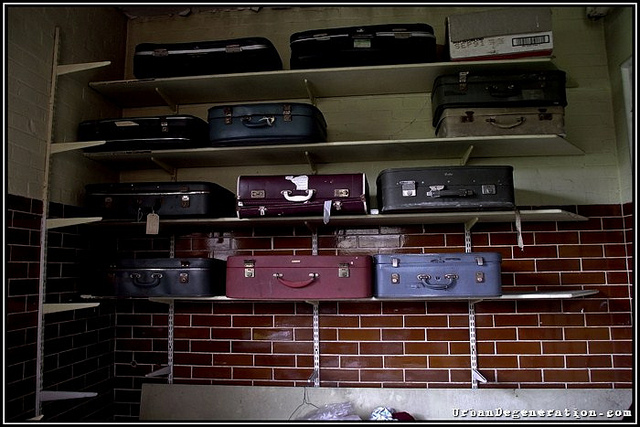

In [58]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
print("Image:")
Image(filename=image_name)

In [59]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: yes
